# Usage

`decoupler` contains different statistical methods to extract biological activities from omics data using prior knowledge. In this notebook we showcase how to use it with some toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading packages

`decoupler` can be imported as:

In [1]:
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-info">

**Note**
    
The first time `decoupler` is imported in an enviroment can be slow. This is due to numba compiling its source code. After the first usage it will be stored in cache, making the import time normal again.

</div>  

## Loading toy data

`decoupler` needs a matrix (`mat`) of molecular readouts (gene expression, logFC, p-values, etc.) and a network (`net`) that relates target features (genes, proteins, etc.) to "source" biological entities (pathways, transcription factors, molecular processes, etc.)

To load the example data-set, simply run:

In [2]:
mat, net = dc.get_toy_data()

This example consists of two small populations of samples (S, rows) with different gene expression patterns (G, columns):

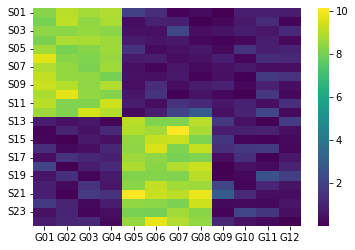

In [3]:
sns.heatmap(mat, cmap='viridis')
plt.show()

Here we can see that some genes seem to be more expressed in one group of samples than in the other and vice-versa. Ideally, we would like to capture these differences in gene programs into interpretable biological entities. In this example we will do it by summarizing gene expression into transcription factor activities.

The toy data also contains a simple `net` consisting of 5 transcription factors (Ts) with specific regulation to target genes (Gs), either positive or negative:

In [4]:
net

,source,target,weight
0,T1,G01,1.0
1,T1,G02,1.0
2,T1,G03,0.7
3,T2,G04,1.0
4,T2,G06,-0.5
5,T2,G07,-3.0
6,T2,G08,-1.0
7,T3,G06,1.0
8,T3,G07,0.5
9,T3,G08,1.0


This network can be visualized like a graph. Green edges are positive regulation (activation), red edges are negative regulation (inactivation):

![](../net_plot.png)

According to this network, the first population of samples should show high activity for T1 and T2, while the second one for T3 and T4. T5 should have no activity in all samples.

## Methods

`decoupler` contains several methods. To check how many are available, run:

In [5]:
dc.show_methods()

,Function,Name
0,run_aucell,AUCell.
1,run_consensus,Consensus score from top methods.
2,run_gsea,Gene Set Enrichment Analysis (GSEA).
3,run_gsva,Gene Set Variation Analysis (GSVA).
4,run_mdt,Multivariate Decision Tree (MDT).
5,run_mlm,Multivariate Linear Model (MLM).
6,run_ora,Over Representation Analysis (ORA).
7,run_udt,Univariate Decision Tree (UDT).
8,run_ulm,Univariate Linear Model (ULM).
9,run_viper,Virtual Inference of Protein-activity by Enric...


Each method models biological activities in a different manner, sometimes returning more than one estimate or providing significance of the estimation. To know what each method returns, please check their documentation like this `?run_mlm`.

To have a unified framework, methods inside `decoupler` have these shared arguments:

* `mat` : input matrix of molecular readouts.
* `net` : input prior knowledge information relating molecular features to biological entities.
* `source`,`target` and `weight` : column names where to extract the information from `net`. 
    * `source` refers to the biological entities.
    * `target` refers to the molecular features.
    * `weight` refers to the "strength" of the interaction (if available, else 1s will be used). Only available for methods that can model interaction weights.
* `min_n` : Minimum of target features per biological entity (5 by default). If less, sources are removed. This filtering prevents obtaining noisy activities from biological entities with very few matching target features in `mat`. For this example data-set we will have to keep it to 0 though.
* `verbose` : Whether to show progress.
* `use_raw` : When the input is an `AnnData` object, whether to use the data stored in it's `.raw` atribute or not (`True` by default).

## Running methods

### Individual methods

As an example, let's first run the Gene Set Enrichment Analysis method (`gsea`), one of the most well-known statistics:

In [6]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
acts, norm_acts, pvals = dc.run_gsea(mat, net, min_n=0, times=100)
acts.head()

source,T1,T2,T3,T4,T5
S01,0.888889,0.711597,-0.555556,-0.50,-0.666667
S02,0.888889,0.699385,-0.555556,-0.50,-0.444444
S03,0.888889,0.551198,-0.444444,-0.75,-0.666667
S04,0.888889,0.607223,-0.666667,-0.50,-0.444444
S05,0.888889,0.732963,-0.888889,-0.50,-0.444444


In the case of `gsea`, it returns a simple estimate of activities (`acts`), a normalised estimate (`norm_acts`) and `pvals` data-frames after doing permutations.

<div class="alert alert-info">

**Note**
    
If `mat` is an `AnnData` instance, results will instead be saved in its `.obsm` attribute.

</div>  

Let us plot the obtained results:

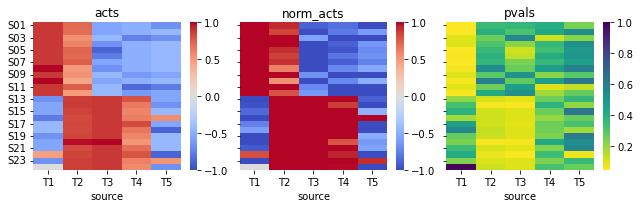

In [7]:
fig, axes = plt.subplots(1,3, figsize=(9,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('norm_acts')
sns.heatmap(norm_acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[2].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[2], vmax=1)

plt.show()

We can observe that for transcription factors T1 and T3, the obtained activities correctly distinguish the two sample populations. T2, on the other hand, should be down for the second population of samples since it is a repressor. This mislabeling of activities happens because `gsea` cannot model weights when inferring biological activities.

When weights are available in the prior knowledge, we definitely recommend using any of the methods that take them into account to get better estimates, one example is the Univariate Linear Model method `ulm`:

In [8]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
acts, pvals = dc.run_ulm(mat, net, min_n=0)
acts.head()

,T1,T2,T3,T4,T5
S01,4.020364,1.667426,-1.378734,-0.243605,-1.188728
S02,4.060294,1.392356,-1.313069,-0.387175,-1.102454
S03,4.189780,1.086979,-1.346471,-0.294281,-1.139018
S04,4.149534,1.395950,-1.332407,-0.273508,-1.197696
S05,4.052074,1.610522,-1.534533,-0.311155,-0.990895


In this case, `ulm` only returns infered activities and their associated p-value.

As before, let us plot the resulting activities:

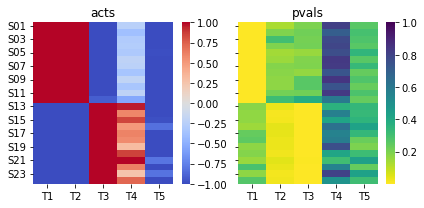

In [9]:
fig, axes = plt.subplots(1,2, figsize=(6,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)

plt.show()

Since `ulm` models weights when estimating biological activities, it correctly assigns T2 as inactive in the second population of samples.

### Multiple methods

`decoupler` also allows to run multiple methods at the same time. Moreover, it computes a consensus score based on the obtained activities across methods, called `consensus`.

By default, `decouple` runs only the top performer methods in our benchmark (`mlm`, `ulm` and `wsum`), and estimates a consensus score across them. Specific arguments to specific methods can be passed using the variable `args`. For more information check `?decouple`. If we wanted to only obtain the consensus score, we could also have used `run_consensus`, check `?run_consensus` for more information.

In [10]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
results = dc.decouple(mat, net, min_n=0, verbose=False)

`decouple` either returns a dictionary of activities and p-values, or stores them in the `AnnData` instance provided. 

Let us see how the consensus score looks like:

In [11]:
# Extract from dictionary
acts = results['consensus_estimate']
pvals = results['consensus_pvals']

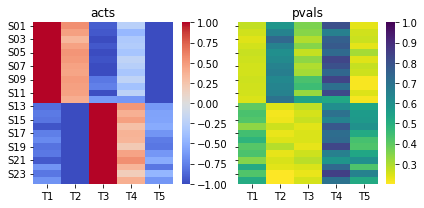

In [12]:
fig, axes = plt.subplots(1,2, figsize=(6,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)

plt.show()

We can observe that the consensus score correctly predicts that T1 and T2 should be active in the first population of samples while T3 and T4 in the second one. T5 is inactive everywhere as expected.